# El Problema

## Red eléctirca "El Espino"

---
![microgrid Espino](https://ars.els-cdn.com/content/image/1-s2.0-S0360544219317682-gr4.jpg)

---

**Objetivo:**

 Optimizar el ***costo*** de la red frente a la incertidumbre de la generación de energía solar y de la demanda de energía

**Alternativas:**

1. Operar la red con reglas:

    - Priorizar consumo de la energía solar
    - Si la generación fotovoltaica es mayor que la demanda, se carga la batería
    - Si la energía solar no alcanza a satisfacer el consumo, se descarrga la batería hasta que alcance el 50% de la carga
    - Si la energía solar y la batería no alcanzan a satisfacer la demanda, se prende el generador de gas
    - El generador carga la batería si la demanda es menor que la generación minima de operación.

2. Aprender una ***política*** que optimize los costos de la red y guíe la elección de una acción dado un estado

Necesitamos definir las ***acciones posibles*** y los ***estados posibles*** y realizar un proceso de aprendizaje de la política

## Estados, acciones, recompensa/pérdida

**Acciones posibles:**

- Generar energía con gas
- Descargar batería para usar energía almacenada
- Cargar batería (almacenar exceso de energía)

**Estados posibles:**

- Demanda Neta:  Demanda de energía - Generación de energía solar
- Estado de carga de la Batería


**Recompensa/pérdida**
- Costo de generación de electricidad

# Bibliotecas

[pymgrid](https://github.com/Total-RD/pymgrid)


In [1]:
!pip install http://github.com/Total-RD/pymgrid/archive/refs/tags/v0.1.0-beta.zip


     - 8.6 MB 6.3 MB/s 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.0 MB/s eta 0:00:00
  Created wheel for pymgrid: filename=pymgrid-0.1.0-py3-none-any.whl size=3423472 sha256=b490a6dbde1ebcba334a07379aea2cdd4ac1f3ea43b12ea871ba38e6e3be05ab
  Stored in directory: /root/.cache/pip/wheels/7f/5a/0d/f5e96701d5cf17e17bb90006eb7b6ea823653c0e72cb3d0d50
Successfully built pymgrid


In [2]:

from pymgrid import MicrogridGenerator as mg

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import time
import sys
import pickle

# Ambiente:
* Arquitectura de la microrred
* Datos históricos de demanda energética y generación solar
* Componentes de la red

### Arquitectura de la microrred

In [3]:
# seleccionamos un ambiente con un arquitectura conveniente para nuestro problema
env = mg.MicrogridGenerator(nb_microgrid=40,
                            random_seed = 7   # el tamaño de los componente de la red es asignado aleatoriamente
                            )
env.generate_microgrid(verbose=False)

red = env.microgrids[32]
print('Arquitecturade la red: \n',red.architecture)

Arquitecturade la red: 
 {'PV': 1, 'battery': 1, 'genset': 1, 'grid': 0}


In [4]:
 red.print_info()

Microgrid parameters


,load,cost_loss_load,cost_overgeneration,cost_co2,PV_rated_power,battery_soc_0,battery_power_charge,battery_power_discharge,battery_capacity,battery_efficiency,...,battery_cost_cycle,genset_polynom_order,genset_polynom_0,genset_polynom_1,genset_polynom_2,genset_rated_power,genset_pmin,genset_pmax,fuel_cost,genset_co2
0,1392,10,1,0.1,1879.2,0.2,574,574,2295,0.9,...,0.02,3,1.442031,0.547353,0.025381,1547,0.05,0.9,0.4,2


Architecture:
{'PV': 1, 'battery': 1, 'genset': 1, 'grid': 0}
Actions: 
dict_keys(['load', 'pv_consummed', 'pv_curtailed', 'pv', 'battery_charge', 'battery_discharge', 'genset'])
Control dictionnary:
['load', 'pv_consummed', 'pv_curtailed', 'pv', 'battery_charge', 'battery_discharge', 'genset']
Status: 
dict_keys(['load', 'hour', 'pv', 'battery_soc', 'capa_to_charge', 'capa_to_discharge'])
Has run mpc baseline:
False
Has run rule based baseline:
False


Cada acción(`Action`) que se aplique a la red será definida por los valores que se pasen a cada una de las claves del diccionario de control.
Cuando se aplique la acción, entonces obtendremos un `Status` nuevo.

### Datos históricos de demanda energética y generación solar

Cada observación es una hora y la longitud de la serie es de un año (8769 horas)

In [5]:
red.print_load_pv()

Load


PV


## Características de los componentes


**Demanda**

In [6]:
red.reset()

In [7]:
 # Variable aleatoria en función del tiempo
red.load

221.48413295528024

**Generación fotovoltaica (pv)**

In [8]:
# variable aleatoria en función del tiempo
red.pv

0.0

**Batería**

In [9]:
## Costante. Cantidad de energía máxima que puede cargar la batería en una hora
red.battery.p_charge_max


574

In [10]:
# Constante. Cantidad de energía máxima que puede descargar la batería en una hora
red.battery.p_discharge_max

574

In [11]:
# Constante. Estado de carga máxima
red.battery.soc_max

1

In [12]:
# Constante. Estado de carga mínima
red.battery.soc_min

0.2

In [13]:
# Variable. Estado de la carga
red.battery.soc

0.2

In [14]:
# Variable dependiente de soc. Cantidad de energía que la batería puede cargar antes de tener carga completa
red.battery.capa_to_charge

2040.0

In [15]:
# Variable dependiente de soc. Cantidad de energía disponible antes de estar totalmente descargada
red.battery.capa_to_discharge

0.0

**Generador de combustibles fósiles (genset)**

In [16]:
# Características del generador
print('Costo del combustible por KWh: ${:0.2f} '.format(red.genset.fuel_cost))
print('Potencia máxima en KW: ', red.genset.rated_power )
print('Operación mínima y máxima: {}%, {}%'.format(red.genset.p_min,
                                                         red.genset.p_max))

Costo del combustible por KWh: $0.40 
Potencia máxima en KW:  1547
Operación mínima y máxima: 0.05%, 0.9%


In [17]:
red.genset.p_min*red.genset.rated_power

77.35000000000001

Con los valores anteriores podemos calcular la potencia en KW máxima y mínima de operación

In [18]:
gen_min = red.genset.p_min * red.genset.rated_power  #potencia mínima del generador
gen_max = red.genset.p_max * red.genset.rated_power  #potencia maxima del generador
gen_min, gen_max

(77.35000000000001, 1392.3)

#  Estados

Cada estado del entorno se determina por dos variables:

- Demanda Neta:  Demanda de energía - Generación de energía solar
- Estado de carga de la batería

In [19]:
# Estado actual
demanda_neta = red.load - red.pv
demanda_neta, red.battery.soc

(221.48413295528024, 0.2)

## Diccionario de control para interactuar con la red

La función `run()` necesita un diccionatrio de control que depende de la arquitectura de nuestra red,  con el que indicaremos las acciones en cada momento.


In [20]:
# Los campos que se pueden usar en el diccionario de control de nuestra red para establecer las acciones son:
red.get_control_dict()

['load',
 'pv_consummed',
 'pv_curtailed',
 'pv',
 'battery_charge',
 'battery_discharge',
 'genset']

`load` y `pv`, se cargan automáticamente.

Nosotros nos concentraremos en si se carga la batería, si se descarga o si se genera energía con fuentes fósiles


In [21]:
#ed.reset()
demanda_neta = red.load - red.pv
print('Estado: ({}, {})\n'.format(demanda_neta, red.battery.soc))

#con los valores del diccionario vamos a establecer la acción a tomar
accion = {
            'pv_consumed': 0,
            'pv_curtail':0,
            'battery_charge':5000 ,
            'battery_discharge':0,
            'genset': 0
          }

red.run(accion)    # Nos regresa un diccionario con un nuevo estatus.


Estado: (221.48413295528024, 0.2)



{'load': 217.51072938340022,
 'hour': 0,
 'pv': 0.0,
 'battery_soc': 2.16078431372549,
 'capa_to_charge': 0,
 'capa_to_discharge': 4050.0}

Corre las dos celdas de código varias veces y observa los resultados

# Definición de las acciones

* accion 0: cargar batería
* accion 1: descargar batería
* acción 2: generación no renovable (genset)

In [22]:
def actions_agent(accion):
    '''  Crea el diccionario para interactuar con la red según la acción tomada:
    0: Cargar batería. La energía a cargar, depende de las variables de estado
    1: Descargar batería.
    2.: Generar energía no renovable (genset).

    Para cualquier de estas acciones es necesario identificar cuanta energía esta
    disponible o cuánta se está demandando a la red, a través de la demanda neta;
    Además es necesario evaluar cuánta energía puede cargarse o descargarse al
    momento de la acción.
    '''

    demanda_neta =  red.load - red.pv
    # Energía que se puede cargar en la batería:
    p_charge = max(0,    # Debe ser mayor a cero
                   min(-demanda_neta + gen_min,    # energía disponible, en el tiempo t
                       red.battery.capa_to_charge, # energía por cargar, antes de tener carga máxima, en el tiempo t
                       red.battery.p_charge_max    # energía que puede cargarse por hora
                       )
                   )

    # Energía que se puede descargar de la batería
    p_discharge = max(
                      0,
                      min(
                          demanda_neta-gen_min,   # energía faltante para cubrir la demanda, en el tiempo t
                          red.battery.capa_to_discharge, # energía disponible, antes de tener carga mínima, en el tiempo t
                          red.battery.p_discharge_max  #  energía que puede descargarse en una hora
                          )
                      )

    control_dic ={}
    if accion == 0:   # Cargar batería
        control_dict= {'pv_consumed': min(red.pv, red.load),
                       'pv_curtailed':0,
                       'battery_charge': p_charge,
                       'battery_discharge': 0,
                       'genset': gen_min
                       }
    elif accion == 1:   # Descargar bateria
        control_dict = {'pv_consummed': min(red.pv, red.load-p_discharge),
                        'pv_curtailed':0,
                        'battery_charge': 0,
                        'battery_discharge': p_discharge,
                        'genset': gen_min
                        }

    elif accion == 2:  #Generación no renovable (genset)
        p_genset = max(gen_min,
                       min(gen_max,
                           max(0, demanda_neta)))
        control_dict = {'pv_consummed': min(red.pv, red.load-p_genset),
                        'pv_curtailed':0,
                        'battery_charge': 0,
                        'battery_discharge': 0,
                        'genset': p_genset
                       }
    return control_dict

In [23]:
#red.reset()  # reiniciar el entorno
print('** Tiempo t **:')
print('load: {0:.2f}, pv: {1:.1f}, battery_soc: {2:.1f}'.format(red.load, red.pv, red.battery.soc))

# Elegir una acción
accion = 0
dict_control = actions_agent(accion)

# Interactuar con la red con la acción elegida
red.run(dict_control)
print('\nDiccionario para interactuar con la red:\n',dict_control)

print('\n** Tiempo t+1 **:')
print('load: {0:.2f}, pv: {1:.1f}, battery_soc: {2:.3f}'.format(red.load, red.pv, red.battery.soc))
print('\nCOSTO DE LA ACCIÓN: ${:.2f} '.format(red.get_cost()))

** Tiempo t **:
load: 217.51, pv: 0.0, battery_soc: 2.2

Diccionario para interactuar con la red:
 {'pv_consumed': 0.0, 'pv_curtailed': 0, 'battery_charge': 0, 'battery_discharge': 0, 'genset': 77.35000000000001, 'load': 217.51072938340022, 'pv': 0.0}

** Tiempo t+1 **:
load: 221.15, pv: 0.0, battery_soc: 2.161

COSTO DE LA ACCIÓN: $1448.02 


# Inicializa la tabla con la política Q

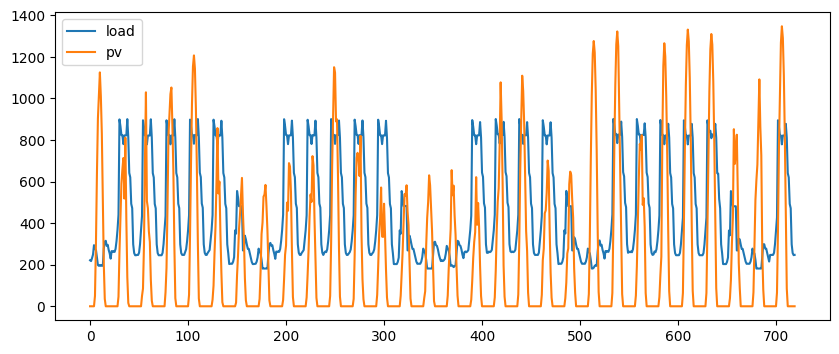

In [47]:
red.set_horizon(720)   # se pueden hacer predicciones hasta por un año: 8769 horas

plt.figure(figsize=(10,4))
plt.plot(red.forecast_load(), label='load')
plt.plot(red.forecast_pv(), label='pv')
plt.legend()
plt.show()

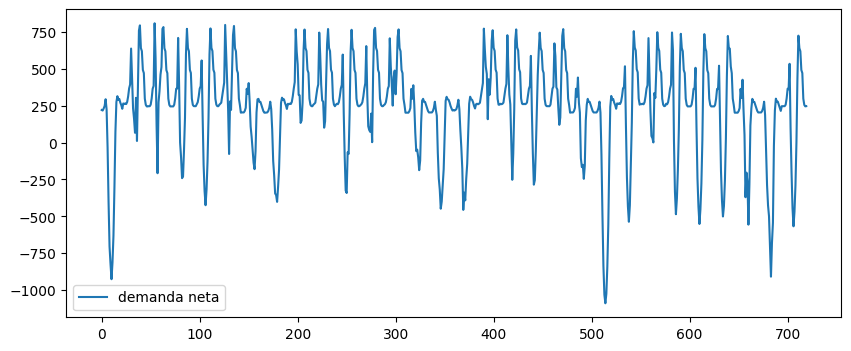

In [49]:
demanda_neta = red.forecast_load() - red.forecast_pv()

plt.figure(figsize=(10,4))
plt.plot(demanda_neta, label='demanda neta')
plt.legend()
plt.show()

In [43]:
demanda_neta = red.load - red.pv
demanda_neta, red.battery.soc

(221.15405361009712, 2.16078431372549)

In [44]:
# Discretizaremos los valores de estados
demanda_neta = int((red.load - red.pv) // 10 * 10)
soc = round(red.battery.soc,1)
demanda_neta, soc

(220, 2.2)

In [97]:
def init_qtable(red, acciones_posibles, horizon):
    red.reset()
    # Demanda neta en un horizonte de un año
    red.set_horizon(horizon)
    demanda_neta = red.forecast_load() - red.forecast_pv()

    #creamos una lista que guardará todas las combinaciones de demanda_neta y estado de la batería
    state = []
    for d_n in range(int(demanda_neta.min()//10),int(demanda_neta.max()//10)+1):  #ciclo entre la demanda neta minima y máxima DISCRETIZADA
        for soc in np.arange(red.battery.soc_min, red.battery.soc_max + 0.1, 0.1):  #ciclo entre el estado de carga de la batería minima y máxima  DISCRETIZADO
            soc = round(soc, 1)
            state.append((d_n*10, soc))
    Q={}
    #Iniciamos el estado Q(s,a) en cero
    for s in state:
        Q[s] = {}
        for a in range(acciones_posibles):
            Q[s][a] = 0

    return Q

In [52]:
Q = init_qtable(red, 3)
print('Total de estados posibles:',len(Q))

Total de estados posibles: 1719


In [53]:
s = 460, 0.6
Q[s] # Para cada estado tenemos un diccionario donde se actualizará el valor para cada acción

{0: 0, 1: 0, 2: 0}

# Entrenamiento del agente

El agente aprenderá de las acciones tomadas en cada estado y de los costos ocasionados por esas acciones

## Funciones auxiliares para el entrenamiento del agente

In [54]:
def max_dict(Qs):
    '''Devuelve la calve del diccionario que tenga el valor máximo'''
    a = max(Qs, key = Qs.get)
    return a

In [55]:
def reitera_o_cambia_accion_edg(accion, ε, acciones_posibles):
  '''Reitera o elige nueva acción, implementando la estrategia epsilon decreasing
  gready.
     accion: acción escogida previamente
     ε: valor actual de epsilon
     acciones_posibles
  '''
  p = np.random.uniform(1.0, 0.0 )  #escogemos un valore entre 0 y 1
  if p < (1 - ε):
        # cuándo epsilon es pequeño, se sigue con la misma acción (Explotación)
        return accion   # sigue con la misma acción
  else:
        # cuando es grande, se escoge una al azar (Exploración)
        return np.random.choice(acciones_posibles)

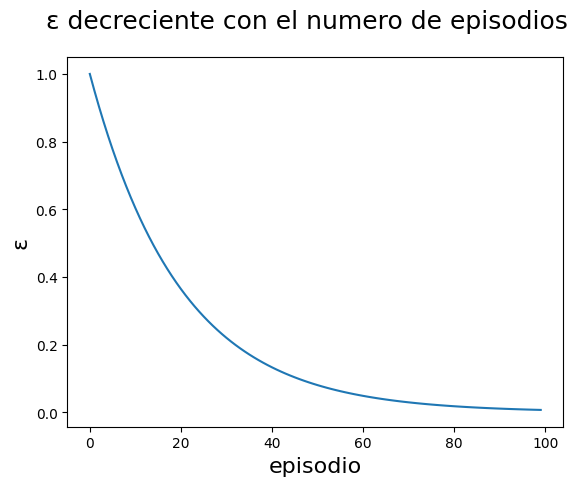

In [56]:
episodios = 100
ε = np.exp(-5 * np.linspace(0, 1, episodios))

fig =plt.figure()
plt.plot(ε)
plt.xlabel('episodio', fontsize=16)
plt.ylabel('ε', fontsize=16)
fig.suptitle('ε decreciente con el numero de episodios', fontsize=18)

plt.show()

In [57]:
def print_welcome(idx):

    if idx == 0:
        print("------------------------------------")
        print("|             WELCOME              |")
        print("------------------------------------")
    elif idx == 1:

        print("t -     STATE  -  ACTION - COST")
        print("================================")


---
## Función de entrenamiento del Agente
---



###Actualización de la política Q

$$Q(S_t,A_t) =Q(S_t,A_t) + \alpha\left[(R_{t+1} + \gamma \max_a {Q(S_{t+1},A_{t+1})})-Q(S_t,A_t)\right]$$

In [125]:
def training_Q_Learning(mg, horizon, episodios):
    '''
    mg: microred,
    horizon: horizonte en horas de cada simulación
    episodios: número de simulaciones para aprender  '''

    acciones_posibles = 3
    Q = init_qtable(mg, acciones_posibles, horizon)    # inicializar tabla Q
    vector_ε = np.exp(-5 * np.linspace(0, 1, episodios))

    print_training = "Training Progressing .   "
    print_welcome(0)
    print("\n")

    for episodio in range(episodios+1):
            #### Control del progreso del entrenamiento   #############################
            if episodio == 0:
                value_print="\rEpisode " + str(episodio) +"/" + str(episodios)
                # sys.stdout.write(value_print)   # guarda en buffer datos a imprimir
                # sys.stdout.flush( )             # forza al buffer a imprimir todo en la términal

            elif episodio % 10 == 0:
                if print_training == "Progreso del entrenamiento .   ":
                    print_training = "Progreso del entrenamiento ..  "
                elif print_training == "Progreso del entrenamiento ..  ":
                    print_training = "Progreso del entrenamiento ...  "
                else:
                    print_training = "Progreso del entrenamiento .   "

            value_print="\r"+ print_training +"Episode " + str(episodio) +"/" + str(episodios)
            sys.stdout.write(value_print)
            sys.stdout.flush()
            ###########################################################################
            episode_cost = 0
            mg.reset()
            ε = vector_ε[episodio-1]

            #  Identifica el estado inicial
            demanda_neta = int((mg.load - mg.pv)//10 *10)
            soc = round(mg.battery.soc, 1)
            s = (demanda_neta, soc)        #estado

            # Elige la accion con el valor más grande del diccionario Q para el estado s
            a = max_dict(Q[s])
            # se decide si se continua con la acción elegida (a) o se escoge nuevamente de forma aleatoria
            a = reitera_o_cambia_accion_edg(a, ε, acciones_posibles)

            for i in range (horizon):

                    # Se ejecuta la acción
                    action = actions_agent(a)
                    mg.run(action)

                    # Se obtiene el costo de la acción y se suma al costo del episodio
                    r = -mg.get_cost()
                    episode_cost += mg.get_cost()

                    # Se guarda el nuevo estado
                    demanda_neta = int((mg.load - mg.pv)//10 *10)
                    soc = round(mg.battery.soc,1)
                    s_ = (demanda_neta, soc)

                    # Se elige nuevamente una acción para ese estado
                    a_ = max_dict(Q[s_])

                    # ACTUALIZA Q
                    alpha = 0.1    # taza de aprendizaje (learning rate)
                    gamma = 0.95   # factor de descuento (prioriza la importancia de la recompensa presente sobre la recompensa futura)
                    if i == horizon-1:
                        Q[s][a] += alpha*(r - Q[s][a])
                    else:
                        old_Q = Q[s][a]
                        target = r + gamma*Q[s_][a_]
                        td_error = target - old_Q
                        Q[s][a] = old_Q + alpha * td_error

                    #actualiza valores de estado y acción para seguir el ciclo
                    a_ = reitera_o_cambia_accion_edg(a_, ε, acciones_posibles)
                    s, a = s_, a_

    return Q

$$Q(S_t,A_t) =Q(S_t,A_t) + \alpha\left[(R_{t+1} + \gamma \max_a {Q(S_{t+1},A_{t+1})})-Q(S_t,A_t)\right]$$

---
## Función para probar la política aprendida

---



In [ ]:
def testing_Q_Learning(mg, Q, horizon):

    mg.reset()
    #  Identifica el estado inicial
    demanda_neta = int((mg.load - mg.pv)//10 *10)
    soc = round(mg.battery.soc,1)
    s = (demanda_neta, soc)

    # Elige la accion con el valor más grande del diccionario Q para el estado s
    a = max_dict(Q[s])

    # Se inicializa la variable de costo para horizonte definido
    total_cost = 0
    print_welcome(1)
    nombre_accion = {0:'carga batería', 1: 'descarga batería', 2:'generación fósil'}
    for i in range (horizon):
        # Se ejecuta la acción
        action = actions_agent(a)
        mg.run(action)

        # Se obtiene el costo de la acción y se suma al costo total
        r = mg.get_cost()
        total_cost += r

        # Se imprime el estado de la red, la acción tomada y el costo generado
        if i < 10:
            print(i," -",(int(demanda_neta),soc),nombre_accion[a],
                  "Costo $",round(r,1), "Costo Total $", round(total_cost,1))
        else:
            print(i,"-",(int(demanda_neta),soc),nombre_accion[a],
                  "Costo $",round(r,1), "Costo Total $", round(total_cost,1))

        # Se calculan los valores del siguiente estado
        demanda_neta = int((mg.load - mg.pv)//10 *10)
        soc = round(mg.battery.soc,1)
        s_ = (demanda_neta, soc)

        # Se obtiene la acción con menor costo en el estado s_
        a_ = max_dict(Q[s_])

        # se actualizan los valores de s y a
        s, a = s_, a_

In [126]:
 %time  Q1 = training_Q_Learning(red, horizon=480, episodios=100)

------------------------------------
|             WELCOME              |
------------------------------------


Progreso del entrenamiento .   Episode 100/100CPU times: user 18 s, sys: 168 ms, total: 18.1 s
Wall time: 18.3 s


In [127]:
Q1_table = pd.DataFrame.from_dict(Q1, orient='index' )
Q1_table.columns=['accion_0', 'accion_1','accion_2']
Q1_table[(Q1_table != 0).any(axis=1)]

accion_0     accion_1     accion_2
-930 0.2   -41.319731   -42.609208   -39.449178
     0.4   -47.319084   -49.790075   -46.912051
     0.5   -13.427240   -13.858507   -14.439547
     0.6   -20.746072   -21.449372   -21.914458
     0.7   -20.391151   -20.563502   -19.432949
...               ...          ...          ...
 790 0.8  -722.579327     0.000000     0.000000
 800 0.2 -5535.046546 -4685.115437 -1752.589217
     0.3 -1399.950021  -666.815986  -582.889079
     0.4  -736.815800  -536.606237   -48.571488
     0.7  -736.815800     0.000000     0.000000

[627 rows x 3 columns]

# Aprendizaje y prueba de la política Q según la cantidad de episodios de aprendizaje

#### 100 episodios

In [128]:
testing_Q_Learning(red ,Q1, 480)

t -     STATE  -  ACTION - COST
0  - (220, 0.2) generación fósil $ 132.9
1  - (210, 0.2) generación fósil $ 263.4
2  - (220, 0.2) generación fósil $ 396.1
3  - (210, 0.2) generación fósil $ 526.6
4  - (230, 0.2) generación fósil $ 665.6
5  - (240, 0.2) generación fósil $ 814.8
6  - (290, 0.2) generación fósil $ 991.3
7  - (220, 0.2) generación fósil $ 1126.5
8  - (-40, 0.2) descarga batería $ 1172.9
9  - (-410, 0.2) generación fósil $ 1219.3
10 - (-710, 0.2) carga batería $ 1277.2
11 - (-830, 0.4) carga batería $ 1335.1
12 - (-930, 0.7) generación fósil $ 1381.5
13 - (-820, 0.7) generación fósil $ 1427.9
14 - (-640, 0.7) carga batería $ 1485.8
15 - (-310, 0.9) carga batería $ 1538.6
16 - (70, 1.0) generación fósil $ 1585.0
17 - (270, 1.0) descarga batería $ 1635.3
18 - (310, 0.9) descarga batería $ 1686.5
19 - (290, 0.8) descarga batería $ 1737.2
20 - (290, 0.7) descarga batería $ 1788.0
21 - (270, 0.6) generación fósil $ 1950.5
22 - (250, 0.6) generación fósil $ 2103.0
23 - (220, 0.6)

#### 200 episodios

In [129]:
 %time  Q2 = training_Q_Learning(red, horizon=480, episodios=200)

------------------------------------
|             WELCOME              |
------------------------------------


Progreso del entrenamiento ..  Episode 200/200CPU times: user 36.1 s, sys: 370 ms, total: 36.5 s
Wall time: 36.8 s


In [130]:
testing_Q_Learning(red,Q2, 480)

t -     STATE  -  ACTION - COST
0  - (220, 0.2) generación fósil $ 132.9
1  - (210, 0.2) generación fósil $ 263.4
2  - (220, 0.2) generación fósil $ 396.1
3  - (210, 0.2) generación fósil $ 526.6
4  - (230, 0.2) generación fósil $ 665.6
5  - (240, 0.2) generación fósil $ 814.8
6  - (290, 0.2) generación fósil $ 991.3
7  - (220, 0.2) generación fósil $ 1126.5
8  - (-40, 0.2) descarga batería $ 1172.9
9  - (-410, 0.2) carga batería $ 1228.9
10 - (-710, 0.4) carga batería $ 1286.8
11 - (-830, 0.6) generación fósil $ 1333.2
12 - (-930, 0.6) generación fósil $ 1379.6
13 - (-820, 0.6) generación fósil $ 1426.0
14 - (-640, 0.6) descarga batería $ 1472.4
15 - (-310, 0.6) carga batería $ 1526.4
16 - (70, 0.8) carga batería $ 1572.9
17 - (270, 0.8) descarga batería $ 1623.3
18 - (310, 0.7) generación fósil $ 1812.3
19 - (290, 0.7) generación fósil $ 1986.6
20 - (290, 0.7) generación fósil $ 2164.0
21 - (270, 0.7) generación fósil $ 2326.5
22 - (250, 0.7) generación fósil $ 2479.0
23 - (220, 0.7)

#### 500 episodios

In [131]:
 %time  Q3 = training_Q_Learning(red, horizon=480, episodios=500)

------------------------------------
|             WELCOME              |
------------------------------------


Progreso del entrenamiento ..  Episode 500/500CPU times: user 1min 27s, sys: 854 ms, total: 1min 28s
Wall time: 1min 29s


In [132]:

testing_Q_Learning(red,Q3, 480)

t -     STATE  -  ACTION - COST
0  - (220, 0.2) generación fósil $ 132.9
1  - (210, 0.2) generación fósil $ 263.4
2  - (220, 0.2) generación fósil $ 396.1
3  - (210, 0.2) generación fósil $ 526.6
4  - (230, 0.2) generación fósil $ 665.6
5  - (240, 0.2) generación fósil $ 814.8
6  - (290, 0.2) generación fósil $ 991.3
7  - (220, 0.2) generación fósil $ 1126.5
8  - (-40, 0.2) generación fósil $ 1172.9
9  - (-410, 0.2) carga batería $ 1228.9
10 - (-710, 0.4) descarga batería $ 1275.3
11 - (-830, 0.4) carga batería $ 1333.2
12 - (-930, 0.6) descarga batería $ 1379.6
13 - (-820, 0.6) descarga batería $ 1426.0
14 - (-640, 0.6) carga batería $ 1483.9
15 - (-310, 0.8) generación fósil $ 1530.3
16 - (70, 0.8) carga batería $ 1576.8
17 - (270, 0.8) generación fósil $ 1742.3
18 - (310, 0.8) generación fósil $ 1931.3
19 - (290, 0.8) generación fósil $ 2105.6
20 - (290, 0.8) generación fósil $ 2282.9
21 - (270, 0.8) generación fósil $ 2445.5
22 - (250, 0.8) generación fósil $ 2597.9
23 - (220, 0.8)

#### 1500 episodios

In [133]:
 %time  Q4 = training_Q_Learning(red, horizon=480, episodios=1500)

------------------------------------
|             WELCOME              |
------------------------------------


Progreso del entrenamiento ...  Episode 1500/1500CPU times: user 4min 24s, sys: 2.64 s, total: 4min 27s
Wall time: 4min 29s


In [134]:

testing_Q_Learning(red,Q4, 480)

t -     STATE  -  ACTION - COST
0  - (220, 0.2) generación fósil $ 132.9
1  - (210, 0.2) generación fósil $ 263.4
2  - (220, 0.2) generación fósil $ 396.1
3  - (210, 0.2) generación fósil $ 526.6
4  - (230, 0.2) generación fósil $ 665.6
5  - (240, 0.2) generación fósil $ 814.8
6  - (290, 0.2) generación fósil $ 991.3
7  - (220, 0.2) generación fósil $ 1126.5
8  - (-40, 0.2) descarga batería $ 1172.9
9  - (-410, 0.2) carga batería $ 1228.9
10 - (-710, 0.4) carga batería $ 1286.8
11 - (-830, 0.6) descarga batería $ 1333.2
12 - (-930, 0.6) generación fósil $ 1379.6
13 - (-820, 0.6) carga batería $ 1437.5
14 - (-640, 0.8) generación fósil $ 1483.9
15 - (-310, 0.8) carga batería $ 1537.9
16 - (70, 1.0) carga batería $ 1584.4
17 - (270, 1.0) generación fósil $ 1749.9
18 - (310, 1.0) generación fósil $ 1938.9
19 - (290, 1.0) generación fósil $ 2113.2
20 - (290, 1.0) generación fósil $ 2290.5
21 - (270, 1.0) generación fósil $ 2453.1
22 - (250, 1.0) descarga batería $ 2503.1
23 - (220, 0.9) ge